<a href="https://colab.research.google.com/github/SohamK2111/Reply-Hackathon/blob/main/DreamBooth_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check GPU is available

!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


In [ ]:
# Download training script (not necessary to clone entire repo) and install necessary libraries

!wget -q https://github.com/huggingface/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

%pip install -qq git+https://github.com/huggingface/diffusers.git

%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy xformers bitsandbytes==0.35.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.3 MB/s eta 0:00:00


In [ ]:
# Enter your huggingface token for model access

from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Create a default accelerate config

from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [ ]:
# Ensure that your accelerate config looks ok

!accelerate env

2023-03-08 12:11:02.908489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-08 12:11:02.908595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-08 12:11:02.908614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

Copy-and-paste the text below in your GitHub issue

- `Accelerate` version: 0.16.0
- Platform: Linux-5.10.147+-x86_64-with-glibc2.29
- Python version: 3.8.10
- Numpy 

In [ ]:
# save a folder with your chosen images

In [ ]:
# Define the model name and image/output paths

MODEL_NAME="CompVis/stable-diffusion-v1-4"
INSTANCE_DIR="/content/dogs"
OUTPUT_DIR="/content/model_weights"

## Below have been used to speed up training:
- gradient checkpointing and the 8-bit optimizer
- xformers
- setting grads to none

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=10 \
  --enable_xformers_memory_efficient_attention

2023-03-08 12:22:49.296287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-08 12:22:49.296927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-08 12:22:49.296961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-08 12:22:54.593327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: lib

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = OUTPUT_DIR
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
    ).to("cuda")

prompt = "A photo of sks dog in a bucket"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

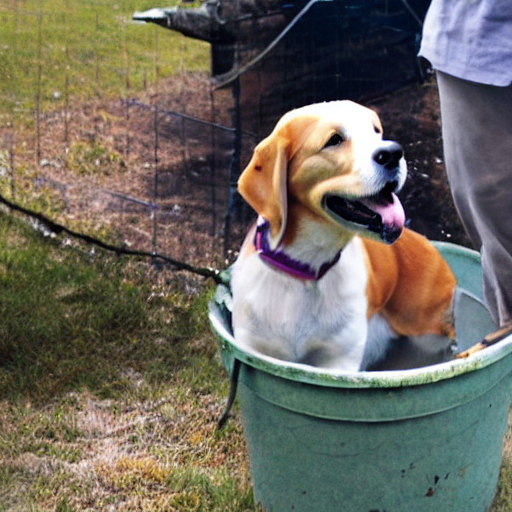

In [ ]:
image

In [ ]:
# If happy, save model weights (e.g. locally, or to HuggingFace) for later use, as files here disappear when Colab runtimes end